<a href="https://colab.research.google.com/github/KyoungmiKwon/Bigdata_Training_at_ITwill/blob/main/Team_Project/C05_KM_SentimentDict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설치

In [ ]:
#Konlpy 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
#Mecab 설치
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [ ]:
!git clone https://github.com/entelecheia/eKoNLpy.git
!pip install /content/eKoNLpy

# import

In [7]:
from ekonlpy.tag import Mecab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Basic Sentiment Dictionary 생성
    
    Dictionary class for
    Korean Sentiment Analysis.

In [6]:
import os
from konlpy.tag import Kkma
from ekonlpy.sentiment.base import LEXICON_PATH, BaseDict
from ekonlpy.sentiment.utils import KTokenizer
from ekonlpy.tag import Mecab

class KSAA(BaseDict):
    '''
    Dictionary class for
    Korean Sentiment Analysis.
    '''

    def init_tokenizer(self, kind=None):
        self._tokenizer = KTokenizer(self._poldict)

    def init_dict(self, kind=None, intensity_cutoff=None):
        path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Project/polar_dictionary.csv')
        with open(path, encoding='utf-8') as f:
            for line in f:
                word = line.split(',')
                w = word[0]
                if w == 'ngram':
                    continue
                
                p = float(word[6].strip())
                n = float(word[3].strip())
                s = p - n
                if len(w) > 1:
                    if s > 0:
                        self._posdict[w] = 1
                        self._poldict[w] = s
                    elif s < 0:
                        self._negdict[w] = -1
                        self._poldict[w] = s


class KOSAC(object):
    def __init__(self):
        self._loaddic()
        self._tagger = Mecab()
        self._ngram = 3
        self._delimiter = ';'
        self._skiptags = ['SF', 'SP', 'SS', 'SE', 'SO', 'SW', 'UN', 'UV', 'UE', 'OL', 'OH', 'ON']

    def _loaddic(self):
        self._polarity = self._loadfile('/content/drive/MyDrive/Colab Notebooks/Project/polar_dictionary.csv')
        self._expressive = self._loadfile(os.path.join(LEXICON_PATH, 'kosac', 'expressive-type.csv'))
        self._intensity = self._loadfile(os.path.join(LEXICON_PATH, 'kosac', 'intensity.csv'))

    def _loadfile(self, file_path, delimiter=','):
        vocab = {}
        if os.path.isfile(file_path):
            with open(file_path) as f:
                for lno, line in enumerate(f):
                    # skip header
                    if lno == 0:
                        headers = line.strip().split(delimiter)
                    else:
                        if len(line) > 0:
                            row = line.strip().split(delimiter)
                            ngram = row[0]
                            # ngram_split = tuple(ngram.split(';'))
                            data = {}
                            for i, header in enumerate(headers):
                                if i > 0:
                                    data[header] = row[i]
                            vocab[ngram] = data
        return vocab

    def morpheme(self, dataset):
        return self.align_morpheme(self._tagger.pos(dataset))

    def align_morpheme(self, morpheme):
        return ['{}/{}'.format(w, t) for w, t in morpheme]

    def percentage(self, obj):
        return {k: v / sum(obj.values()) for k, v in obj.items()}

    def calc(self, keypairs, source, target, func):
        for keypair in keypairs:
            sourcekey = keypair[0]
            targetkey = keypair[1]
            if sourcekey in source:
                sourcedata = source[sourcekey]
                sourcedata = float(sourcedata)
                target[targetkey] = func(sourcedata, target[targetkey])
        return target

    def match(self, data, pairdata, keypairs):
        ret = {k[1]: 0 for k in keypairs}
        for m in data:
            if m in pairdata:
                currentdata = pairdata[m]
                ret = self.calc(keypairs, currentdata, ret,
                                lambda s, t: t + s)
        return self.percentage(ret)

    def polarity(self, data):
        return self.match(data,
                          self._polarity,
                          [['COMP', 'com'],
                           ['POS', 'pos'],
                           ['NEG', 'neg'],
                           ['NEUT', 'neut'],
                           ['None', 'none']])

    def intensity(self, data):
        return self.match(data,
                          self._intensity,
                          [['High', 'high'],
                           ['Low', 'low'],
                           ['Medium', 'medium'],
                           ['None', 'none']])

    def expressive(self, data):
        return self.match(data,
                          self._expressive,
                          [['dir-action', 'dir-action'],
                           ['dir-explicit', 'dir-explicit'],
                           ['dir-speech', 'dir-speech'],
                           ['indirect', 'indirect'],
                           ['writing-device', 'writing-device']])

    def analyze(self, dataset):
        dataset = self.parse(dataset)
        ret = {}
        for analysis in ['polarity', 'intensity', 'expressive']:
            func = getattr(self, analysis)
            ret[analysis] = func(dataset)
        return ret

    def parse(self, dataset):
        tokens = []
        if type(dataset) == list:
            for t in dataset:
                tokens += self.morpheme(t)
        elif type(dataset) == str:
            tokens = self.morpheme(dataset)
        else:
            raise ValueError('The dataset has to be string or list of string type.')

        return self.ngramize(tokens)

    def ngramize(self, tokens):
        ngram_tokens = []
        tokens = [w for w in tokens if w.split('/')[1] not in self._skiptags]
        for pos in range(len(tokens)):
            for gram in range(1, self._ngram + 1):
                token = self.get_ngram(tokens, pos, gram)
                if token:
                    ngram_tokens.append(token)
        return ngram_tokens

    def get_ngram(self, tokens, pos, gram):
        if pos < 0:
            return None
        if pos + gram > len(tokens):
            return None
        token = tokens[pos]
        for i in range(1, gram):
            token += self._delimiter + tokens[pos + i]
        return token

## 감성 극성계산 위한 함수들 생성

In [8]:
import abc
from ekonlpy.utils import installpath

LEXICON_PATH = '%s/data/lexicon' % installpath


class BaseDict(object):
 

    __metaclass__ = abc.ABCMeta

    TAG_POL = 'Polarity'
    TAG_SUB = 'Subjectivity'
    TAG_POS = 'Positive'
    TAG_NEG = 'Negative'

    EPSILON = 1e-6

    def __init__(self, tokenizer=None, kind=None, intensity_cutoff=None):
        self._posdict = {}
        self._negdict = {}
        self._poldict = {}
        self._intensity_cutoff = intensity_cutoff
        self.init_dict(kind, intensity_cutoff)
        if tokenizer is None:
            self.init_tokenizer(kind)
        else:
            self._tokenizer = tokenizer

        assert len(self._posdict) > 0 and len(self._negdict) > 0

    def tokenize(self, text):

        return self._tokenizer.tokenize(text)


    @abc.abstractmethod
    def init_tokenizer(self, kind):
        pass

    @abc.abstractmethod
    def init_dict(self, kind, intensity_cutoff):
        pass

    def _get_score(self, term, by_count=True):

        if by_count:
            if term in self._posdict.keys():
                return self._posdict[term]
            elif term in self._negdict.keys():
                return self._negdict[term]
            else:
                return 0
        else:
            if term in self._poldict.keys():
                return self._poldict[term]
            else:
                return 0

    def get_score(self, terms, by_count=True):

        assert isinstance(terms, list) or isinstance(terms, tuple)
        score_li = [self._get_score(t, by_count) for t in terms]
        pos_score_li = [s for s in score_li if s > 0]
        neg_score_li = [s for s in score_li if s < 0]

        s_pos = sum(pos_score_li)
        s_neg = sum(neg_score_li)

        s_pol = (s_pos + s_neg) * 1.0 / (((s_pos - s_neg) if by_count else len(score_li)) + self.EPSILON)
        s_sub = (len(pos_score_li) + len(neg_score_li)) * 1.0 / (len(score_li) + self.EPSILON)

        return {self.TAG_POS: s_pos,
                self.TAG_NEG: s_neg,
                self.TAG_POL: s_pol,
                self.TAG_SUB: s_sub}

# Tokenkizer 생성 using in Sentiment dictionary

    An abstract class for tokenize text.

    The default tokenizer for KSA sub class.
    The output of the tokenizer is tagged by Kkma.   
    

In [10]:
import abc
import re
import nltk
import os
from ekonlpy.tag import Mecab
from ekonlpy.sentiment.base import LEXICON_PATH
from konlpy.tag import Kkma


class BaseTokenizer(object):
    '''
    An abstract class for tokenize text.
    '''

    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def tokenize(self, text):
        '''Return tokenized temrs.
        
        :type text: str
        
        :returns: list 
        '''
        pass

    # @abc.abstractmethod
    # def ngramize(self, tokens):
    #     '''Return n-gramized temrs.
    #
    #     :type tokens: list of tokens
    #
    #     :returns: list
    #     '''
    #     pass


class KTokenizer(BaseTokenizer):
    '''
    The default tokenizer for KSA sub class.
    The output of the tokenizer is tagged by Kkma.
    '''

    def __init__(self, vocab=None):
        self._tagger = Kkma()
        self._vocab = vocab
        self._min_ngram = 1
        self._ngram = 3
        self._delimiter = ';'
        self._skiptags = ['SF', 'SP', 'SS', 'SE', 'SO', 'SW', 'UN', 'UV', 'UE', 'OL', 'OH', 'ON']

    def tokenize(self, text):
        tokens = []
        if type(text) == list:
            for t in text:
                tokens += self.morpheme(t)
        elif type(text) == str:
            tokens = self.morpheme(text)
        else:
            raise ValueError('The dataset has to be string or list of string type.')

        return self.ngramize(tokens)

    def ngramize(self, tokens):
        ngram_tokens = []
        tokens = [w for w in tokens if w.split('/')[1] not in self._skiptags]
        for pos in range(len(tokens)):
            for gram in range(1, self._ngram + 1):
                token = self.get_ngram(tokens, pos, gram)
                if token:
                    if self._vocab is None:
                        ngram_tokens.append(token)
                    else:
                        if token in self._vocab:
                            ngram_tokens.append(token)
        return ngram_tokens

    def get_ngram(self, tokens, pos, gram):
        if pos < 0:
            return None
        if pos + gram > len(tokens):
            return None
        token = tokens[pos]
        for i in range(1, gram):
            token += self._delimiter + tokens[pos + i]
        return token

    def morpheme(self, dataset):
        return self.align_morpheme(self._tagger.pos(dataset))

    def align_morpheme(self, morpheme):
        return ['{}/{}'.format(w, t) for w, t in morpheme]

# 데이터 불러오기

In [134]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Project/Sentiment_dict.xlsx'
data = pd.read_excel(file_path)
data[10:15]

,No,Code,Date,Journal,Title,Text,URL,Sample Y/N,In Charge,S
10,61,5930,2021.04.13 17:49,서울경제,삼성·TSMC·인텔 모두 美 증설···3년 뒤 파운드리 시장 판 바뀐다,"美, 설계서 생산까지 주도권 확보조 바이든 미국 대통령이 12일(현지 시간) 백악관...",https://finance.naver.com/item/news_read.nhn?a...,A,JY,0
11,62,5930,2021.04.13 17:45,한국경제,"바이든, 웨이퍼 흔들며 ""기다릴 이유 없다""…삼성에 '공격투자' 압박","백악관 화상회의서 기업들에 노골적 투자 요구美, 자국 생산확대 주문에 인텔 등 경쟁...",https://finance.naver.com/item/news_read.nhn?a...,A,JY,-1
12,64,5930,2021.04.13 17:18,매일경제,"삼성전자, 사업장 2곳 사내식당 결국 외부 개방","수원·기흥사업장 식당 외부업체 경쟁입찰각각 신세계푸드, 풀무원푸드앤컬처 선정[사진출...",https://finance.naver.com/item/news_read.nhn?a...,Y,SJ,0
13,65,5930,2021.04.13 16:50,매일경제,"삼성전자, 사내식당 2곳 급식 외부 개방",신세계·풀무원푸드 선정삼성전자가 사내식당 2곳에 대해 실시한 외부 급식업체 경쟁입찰...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,0
14,70,5930,2021.04.13 16:52,이데일리,美바이든 투자 압박에 고심하는 삼성전자…총수 부재의 딜레마,"바이든, '반도체 대응 CEO 서밋'에서 투자 요청삼성전자, 170억달러 규모 증설...",https://finance.naver.com/item/news_read.nhn?a...,A,JY,-1


In [135]:
data.groupby(['S'])['No'].count()

S
-1    314
 0    374
 1    686
Name: No, dtype: int64

# 셋트 분리

In [136]:
# 부정,중립,긍정으로 할 경우
X = data[['No','Text']]
y = data['S']

In [137]:
# 긍정, 긍정이 아닌 경우 : 이진분류로 치환시
y_1 = data['S'].replace(-1,0)
y = pd.DataFrame(y_1)

In [138]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,             
                                          test_size = 0.2,
                                          stratify = y)

In [139]:
std_data = pd.concat([X_tr,y_tr],axis=1).reset_index(drop=True)
std_data[10:15]

,No,Text,S
10,352,미국과 중국의 세계 반도체 공급망 패권 경쟁이 가열되면서 국내 반도체 산업도 긴장이...,0
11,2319,핀크리얼리 세대별 보유주식 분석 결과2030세대 54% 삼성전자(우선주 포함) 보유...,1
12,5372,스팀 기술 눈으로 확인할 수 있는 새 TV 광고 선보여[이데일리 김종호 기자] LG...,1
13,547,샤오미 최초의 폴더블폰 '미믹스폴드' 출시가격 172만원에서 최고 189만원자체 개...,0
14,1930,"케이프투자증권 분석디스플레이·핸드폰 등 추정치 비슷…반도체가 하회""4분기는 반도체 ...",0


# 극성값 계산

In [141]:
ksaa = KSAA()

pola_std_text = []
for i in range(len(std_data)): # 기사 하나 씩
  
    polar = 0
    for k in std_data['Text'][i].split('.'): # 하나의 기사에서 한 문장           
        tokens = ksaa.tokenize(k)
        # print(i,tokens)

        token_lst = []
        for a in tokens:                    #> ['가/VV', '되/XSV', '확산/NNG', '따르/VV', '거리/NNG', '기/NNG', '정착/NNG', '시장/NNG', '이/JKS;불/VV', '불/VV', '등/NNB', '등/NNB;을/JKO'......]
            one_dot = a.split('/')          #> ['확산', 'NNG']
            if len(one_dot[0]) != int(1):   #>  '확산'
                join_dot= '/'.join(one_dot) #>   확산/NNG
                token_lst.append(join_dot)
        
        if len(token_lst) < int(2) :
            token_lst=[]
        
        # print(token_lst)
        score = ksaa.get_score(token_lst)   #> {'Positive': 55, 'Negative': -18, 'Polarity': 0.506849308125352, 'Subjectivity': 0.9999999863013701}
        polar += score['Polarity']
        sen_num = len(std_data['Text'][i].split('.')) #> 문장 수
    
    pola_std_text.append(polar/sen_num)

std_data['polarity_std'] = pola_std_text


In [142]:
std_data.groupby(['S'])['polarity_std'].median(), std_data.groupby(['S'])['polarity_std'].mean()

(S
 0    0.254565
 1    0.365882
 Name: polarity_std, dtype: float64, S
 0    0.240956
 1    0.352386
 Name: polarity_std, dtype: float64)

In [143]:
std_data.groupby(['S'])['polarity_std'].min(), std_data.groupby(['S'])['polarity_std'].max()

(S
 0   -0.333333
 1   -0.083004
 Name: polarity_std, dtype: float64, S
 0    0.728768
 1    0.800000
 Name: polarity_std, dtype: float64)

In [150]:
a = std_data[std_data['S']== 0]
b = std_data[std_data['S']== 1]

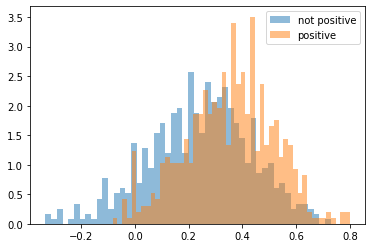

In [166]:
plt.hist(x=a['polarity_std'],label = 'not positive',bins=50,density=True, alpha = 0.5)
plt.hist(x=b['polarity_std'],label = 'positive',bins=50,density=True ,  alpha = 0.5)
plt.legend()
plt.show()

# 극성값에 따른 정확도 측정

In [176]:
accuracy_by_std = []

for standard in np.arange(-0.08, 0.80, 0.001):
    predict = []
    for polarity in std_data['polarity_std']:
        if polarity > standard :
            predict.append(1)
        else:
            predict.append(0)
    accuracy = np.sum(np.equal(std_data['S'],predict)) / len(std_data)
    accuracy_by_std.append(accuracy)

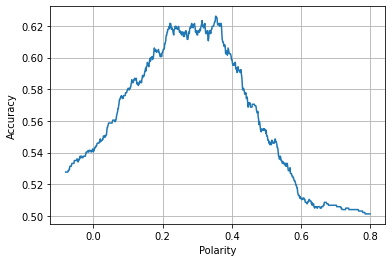

In [177]:
x = np.arange(-0.08, 0.80, 0.001)
y = accuracy_by_std

plt.plot(x,y)
plt.xlabel('Polarity')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [185]:
# 정확도 max 값, 최대 정확도의 인덱스 값 , 정확도 최대의 극성 기준 값
max(accuracy_by_std) , accuracy_by_std.index(max(accuracy_by_std)) , std_data['polarity_std'][accuracy_by_std.index(max(accuracy_by_std))]

(0.6260236578707916, 433, 0.44192977638886327)